# import package

[정말 많은 도움을 받은 주피터 링크](https://github.com/bavafaali/GM-Score_Matching/blob/main/Score_Matching_SwissRoll.ipynb)

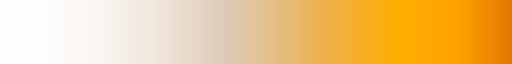

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import imageio
from IPython.display import clear_output
from IPython.display import HTML
from IPython.display import Image
from IPython.display import Video
from tqdm.auto import tqdm
from scipy.stats import multivariate_normal
import torch
import torch.nn as nn
import time

def contourf(mean,cov,plot_lim,num=100):
    x = np.linspace(-plot_lim, plot_lim, num)
    y = np.linspace(-plot_lim, plot_lim, num)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    rv = multivariate_normal(mean, cov)
    Z = rv.pdf(pos)
    return X,Y,Z
def pdf(mean,cov,data_num):
    return np.random.multivariate_normal(mean,cov,data_num).T

# 1-d normal distribution일 때,
# def quiver(mean,cov,plot_lim,num =20):
#     x = np.linspace(-plot_lim, plot_lim, num)
#     y = np.linspace(-plot_lim, plot_lim, num)
#     X, Y = np.meshgrid(x,y)
#     U = (mean[0]-X)/(cov[0][0])
#     V = (mean[1]-Y)/(cov[1][1])
#     return X,Y,U,V

# Define the score function
def score_function(x, mu, Sigma):
    return -np.linalg.inv(Sigma) @ (x-mu)

def quiver(mean, cov, plot_lim=8,num=50,sampling_rate = 2):
    # if distribution_num>1:
    #     assert np.array(mean).size == distribution_num*2,"Assert! mean size is fault"
    #     assert np.array(cov).size  == distribution_num*4,"Assert! Cov size is fault"
    x = np.linspace(-plot_lim, plot_lim, num)
    y = np.linspace(-plot_lim, plot_lim, num)
    X, Y = np.meshgrid(x, y)
    # Compute the score function for each point on the grid
    Z = np.zeros(X.shape + (2,))
    #각 x,y의 mesh grid에 대해서 계산을 해야함. point wise로 score를 구한다고 생각하면 될 듯
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = score_function(np.array([X[i, j], Y[i, j]]), mean, cov)
    X_quiver = X[::sampling_rate, ::sampling_rate]
    Y_quiver = Y[::sampling_rate, ::sampling_rate]
    Z_quiver = Z[::sampling_rate, ::sampling_rate]
    return X_quiver,Y_quiver,-Z_quiver # so we have to multiple -
def generate_gif(filenames:list ,gif_name:str,removing=True,
                 gif_config = {
    'loop':0, ## 0으로 세팅하면 무한 반복, 3으로 설정하면 3번 반복
    'duration': 0.5 ## 다음 화면으로 넘어가는 시간
    }):
    print("creating gif\n")
    print(gif_name)
    with imageio.get_writer(gif_name, mode='I',**gif_config) as writer:
        for filename in tqdm(filenames,leave=False):
            image = imageio.v2.imread(filename)
            writer.append_data(image)

    print("Finish creating\n")

    if removing:
        Removing(filenames)
    return


def quiver_max(Z_quiver1,Z_quiver2):
    norms1 = np.linalg.norm(Z_quiver1, axis=2)
    norms2 = np.linalg.norm(Z_quiver2, axis=2)

    # Create a mask for the quiver plot
    mask = norms1 < norms2

    # Apply the mask to the quiver data
    Z_quiver_max = np.where(mask[..., None], Z_quiver1, Z_quiver2)
    return Z_quiver_max


def Removing(filenames):
    print('Removing Images\n')
    for filename in set(filenames):
        os.remove(filename)
    print('done')
noise2d = lambda num:np.random.multivariate_normal([0,0],np.identity(2),num).T
noise1d = lambda num:np.random.multivariate_normal([0],np.identity(1),num).T

from matplotlib.colors import LinearSegmentedColormap
# colors = ['#FFFFFF','#CF7CDE','#B472CC','#A468BA','#7E508F']
colors = ["#FFFFFF","#DEC9B3","#EFB14E","#FFAE00","#FFA200","#E37900"]
cmap = LinearSegmentedColormap.from_list('my_cmap',colors,gamma=2)
cmap



# TEST

In [25]:
# mean = [0,10]
# cov = [[10,0],[0,12]]


# x,y = np.random.multivariate_normal(mean,cov,100).T
# print(x.shape, y.shape)
# plt.plot(x,y,'x')
# plt.grid(True)
# plt.xlim([-100,100])
# plt.ylim([-100,100])
# plt.show()

--------

# Distribution setting

p1:shape (2, 1280)// p2:shape (2, 1280)
256 1024
(2, 256) (2, 1024)
(2, 1280)


Text(0.5, 1.0, 'i.i.d samples p = 1/5 N([-5,-5],I)+4/5 N([5,5],I)')

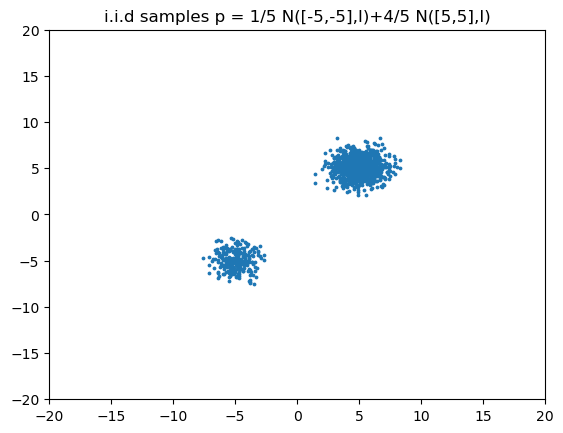

In [2]:
mean = np.array([[-5,-5],[5,5]])

plot_lim = 20
# I = np.identity(2)
cov = np.array([[[1,0],[0,1]],
                [[1,0],[0,1]]])
data_num = 1280
lim = [-plot_lim,plot_lim]

##############
p1 = pdf(mean[0],cov[0],data_num)
p2 = pdf(mean[1],cov[0],data_num)
pi = 1/5
print("p1:shape {}// p2:shape {}".format(p1.shape, p2.shape))
print(int(data_num*pi),int(data_num*(1-pi)))
p1 = p1[:,:int(data_num*pi)]
p2 = p2[:,:int(data_num*(1-pi))]
print(p1.shape, p2.shape)
###########
# cov =
data = np.hstack((p1,p2))
print(data.shape)

plt.scatter(data[0],data[1],s=3,c='#1f77b4')
plt.xlim(lim)
plt.ylim(lim)

plt.title("i.i.d samples p = 1/5 N([-5,-5],I)+4/5 N([5,5],I)")

In [27]:
img_path = "./wrong_langevin/"
if not os.path.isdir(img_path):  #path가 존재하지 않는다면 path를 생성합니다.
    os.mkdir(img_path)


# Forward Processing

In [16]:

show = False
filenames = []
forward_list =[]
for i in tqdm(range(100)):
    if i==0:
        forward_list.append(data)

    else:
        sample = forward_list[-1]
        N = noise2d(len(sample[0]))
        forward_list.append(sample+N)

    # xt_1 = p[0]
    # yt_1 = p[1]
    # xt = xt_1 + score(mean[idx],I,xt_1)+(np.sqrt(epsilon)*noise2(len(xt_1)))
    # yt = yt_1 + score(mean[idx],I,yt_1)+(np.sqrt(epsilon)*noise2(len(yt_1))
    # data_list[idx].append(np.vstack((xt,yt)))

    plt.xlim(lim)
    plt.ylim(lim)
    plt.title(f"{i}_th i.i.d forward")
    x,y = forward_list[-1]

    X,Y,Z = contourf(mean[0],cov[0],plot_lim,100)
    A,B,C = contourf(mean[1],cov[1],plot_lim,100)

    plt.contourf(np.hstack((X,A)),np.hstack((Y,B)),np.hstack((Z,C)),levels=50,cmap=cmap) #levels means # of circle
    plt.colorbar()

    plt.scatter(x,y,s=3,c='#1f77b4')


        # plt.grid(True)
    filename = f"{img_path}/{i}_iteration.png"
    filenames.append(filename)
    plt.tight_layout()
    plt.savefig(filename,dpi=200)
    if show:
        plt.show()
        time.sleep(0.01)

        clear_output(wait=True)
    plt.close()


  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
gif_path = "./gif/"
if not os.path.isdir(gif_path):  #path가 존재하지 않는다면 path를 생성합니다.
    os.mkdir(gif_path)


In [18]:
gif_config = {
    'loop':0, ## 0으로 세팅하면 무한 반복, 3으로 설정하면 3번 반복
    'duration': 10 ## 다음 화면으로 넘어가는 시간
}
gif_name = './gif/wrong.gif'
generate_gif(filenames,gif_name,removing=True,gif_config=gif_config)

creating gif

./gif/wrong.gif


  0%|          | 0/100 [00:00<?, ?it/s]

Finish creating

Removing Images

done


In [ ]:
Image(open(f'{gif_name}','rb').read(),width=500, height=500)

forward가 잘 되는 것을 확인할 수 있습니다.

# 2개의 가우시안에 대하여 score를 구할경우 문제가 발생함
- score의 평균을 가르키는 문제 발생

In [ ]:
mean = np.array([[-5,-5],[5,5]])

plot_lim = 8
cov = [[[1,0],[0,1]],[[3,0],[0,3]]]
sampling_rate= 2
## caculate each distribution direction
plt.figure(figsize=(15,15))
# cov = np.identity(2)
X_quiver,Y_quiver,Z_quiver1 = quiver(mean[0],cov[0],plot_lim,50,sampling_rate)
X_quiver,Y_quiver,Z_quiver2 = quiver(mean[1],cov[1],plot_lim,50,sampling_rate)

Z_quiver_max= quiver_max(Z_quiver1,Z_quiver2)
Z_quiver_max = Z_quiver1+ Z_quiver2
X,Y,Z = contourf(mean[0],cov[0],plot_lim,100)
Q,W,E = contourf(mean[1],cov[1],plot_lim,100)

X,Y,Z = np.hstack((X,Q)),np.hstack((Y,W)),np.hstack((Z,E))

# plt.scatter()
plt.figure(figsize=(6,6))
plt.contourf(X,Y,Z,levels=30,cmap=cmap) #levels means # of circle
plt.colorbar()
plt.quiver(X_quiver, Y_quiver, Z_quiver_max[..., 0], Z_quiver_max[..., 1], color='black')
plt.title(f'N({mean[0],mean[0]},I)')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('./vectorfile_two_normal.png')
plt.show()



## 두개의 distribution을 사용하여 vector를 계산할 경우 이상한 부분이 생김

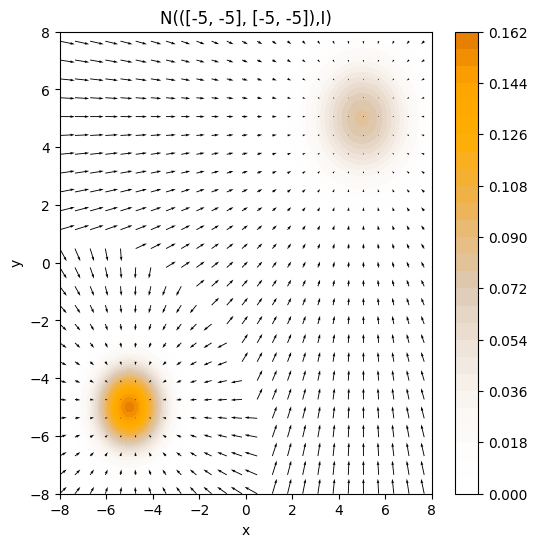

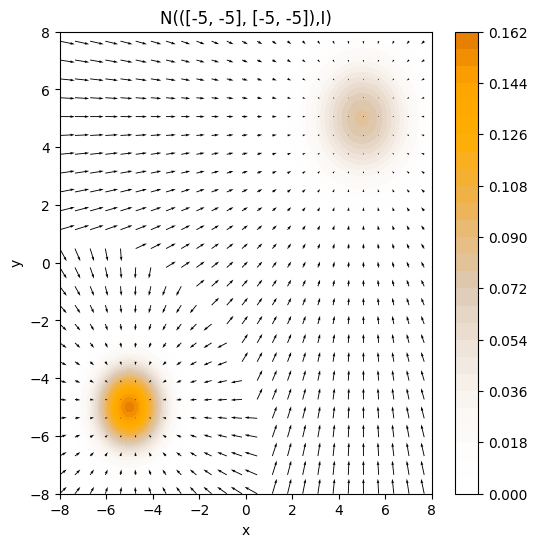

In [21]:
mean = [[-5,-5],[5,5]]
plot_lim = 8
cov = [[[1,0],[0,1]],[[2,0],[0,2]]]
sampling_rate= 2
## caculate each distribution direction

# cov = np.identity(2)
X_quiver,Y_quiver,Z_quiver1 = quiver(mean[0],cov[0],plot_lim,50,sampling_rate)
X_quiver,Y_quiver,Z_quiver2 = quiver(mean[1],cov[1],plot_lim,50,sampling_rate)

# Compute the norms of the vectors
norms1 = np.linalg.norm(Z_quiver1, axis=2)
norms2 = np.linalg.norm(Z_quiver2, axis=2)

# Create a mask for the quiver plot
mask = norms1 < norms2

# Apply the mask to the quiver data
Z_quiver_max = np.where(mask[..., None], Z_quiver1, Z_quiver2)
# Z_quiver_max  = Z_quiver1+Z_quiver2
X,Y,Z = contourf(mean[0],cov[0],plot_lim,100)
Q,W,E = contourf(mean[1],cov[1],plot_lim,100)

X,Y,Z = np.hstack((X,Q)),np.hstack((Y,W)),np.hstack((Z,E))

# plt.scatter()
plt.figure(figsize=(6,6))
plt.contourf(X,Y,Z,levels=30,cmap=cmap) #levels means # of circle
plt.colorbar()
plt.quiver(X_quiver, Y_quiver, -Z_quiver_max[..., 0], -Z_quiver_max[..., 1], color='black')
plt.title(f'N({mean[0],mean[0]},I)')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig("./max_vectorfield.png")
plt.show()



In [28]:
mean = np.array([[-5,-5],[5,5]])
plot_lim = 10
cov = np.array([[[1,0],[0,1]],
                [[1,0],[0,1]]])
data_num = 1280
epsilon = 1e-1
lim = [-plot_lim,plot_lim]

##############
p1 = pdf(mean[0],cov[0],data_num)
p2 = pdf(mean[1],cov[1],data_num)
pi = 1/5
print("p1:shape {}// p2:shape {}".format(p1.shape, p2.shape))
print(int(data_num*pi),int(data_num*(1-pi)))
p1 = p1[:,:int(data_num*pi)]
p2 = p2[:,:int(data_num*(1-pi))]
print(p1.shape, p2.shape)
###########
# cov =
data = np.hstack((p1,p2))
print(data.shape)

p1:shape (2, 1280)// p2:shape (2, 1280)
256 1024
(2, 256) (2, 1024)
(2, 1280)


# Langevin dynamics

In [ ]:
show = False
filenames = []
backward_list =[]
for i in tqdm(range(50)):
    if i==0:
        backward_list.append(forward_list[-1])

    else:
        sample = backward_list[-1]
        # N = noise(len(sample[0])) #축 하나의 갯수를 일단 뽑고
        # backward_list.append(sample+N)
        xt_1 = sample[:,:sample.shape[1]//2]
        xt_2 = sample[:,sample.shape[1]//2:]

        score1 = score_function(xt_1,mean[0].reshape(-1,1), cov[0])
        score2 = score_function(xt_2,mean[1].reshape(-1,1), cov[1])

        xt1 = xt_1 + score1*epsilon+ (np.sqrt(epsilon)*noise2d(xt_1.shape[1]))
        xt2 = xt_2 + score2*epsilon+(np.sqrt(epsilon)*noise2d(xt_2.shape[1]))


#         xt_1 = sample[0]
#         yt_1 = sample[1]

#         score1_x = score_function(mean[0][0],I[0][0],xt_1)
#         score1_y = score_function(mean[0][1],I[0][0],yt_1)

#         score2_x = score_function(mean[1][0],I[1][1],xt_1)

#         score2_y = score_function(mean[1][1],I[1][1],yt_1)



        # xt = xt_1 + (score1_x+score2_x)*epsilon+(np.sqrt(epsilon)*noise2(len(xt_1)))
        # yt = yt_1 + (score1_y+score2_y)*epsilon+(np.sqrt(epsilon)*noise2(len(yt_1)))
        # backward_list.append(np.vstack((xt,yt)))
        backward_list.append(np.hstack((xt1,xt2)))


    X,Y,Z = contourf(mean[0],cov[0],plot_lim,100)
    A,B,C = contourf(mean[1],cov[1],plot_lim,100)

    plt.contourf(np.hstack((X,A)),np.hstack((Y,B)),np.hstack((Z,C)),levels=50,cmap=cmap) #levels means # of circle
    plt.colorbar()


    # A,B,C,D = quiver(mean[0],I,plot_lim,plot_lim)
    # E,F,G,H = quiver(mean[1],I,plot_lim,plot_lim)

    # A,B,C,D = quiver(mean,cov,plot_lim,plot_lim)

    # plt.quiver(np.hstack((A,E)),np.hstack((B,F)),np.hstack((C,G)),np.hstack((D,H)),width=0.003,scale=200) # mesh X ,Y ,gradient X, gradient Y


    plt.xlim(lim)
    plt.ylim(lim)
    plt.title(f"{i}_th langevin")
    x,y = backward_list[-1]
    plt.scatter(x,y,s=3,c='#1f77b4')


        # plt.grid(True)
    filename = f"{img_path}/reverse_{i}_iteration.png"
    filenames.append(filename)
    plt.tight_layout()
    plt.savefig(filename,dpi=200)
    if show:
        plt.show()
        time.sleep(0.01)

        clear_output(wait=True)
    plt.close()


  0%|          | 0/50 [00:00<?, ?it/s]

creating gif

./gif/wrong_reverse.gif


  0%|          | 0/50 [00:00<?, ?it/s]

Finish creating



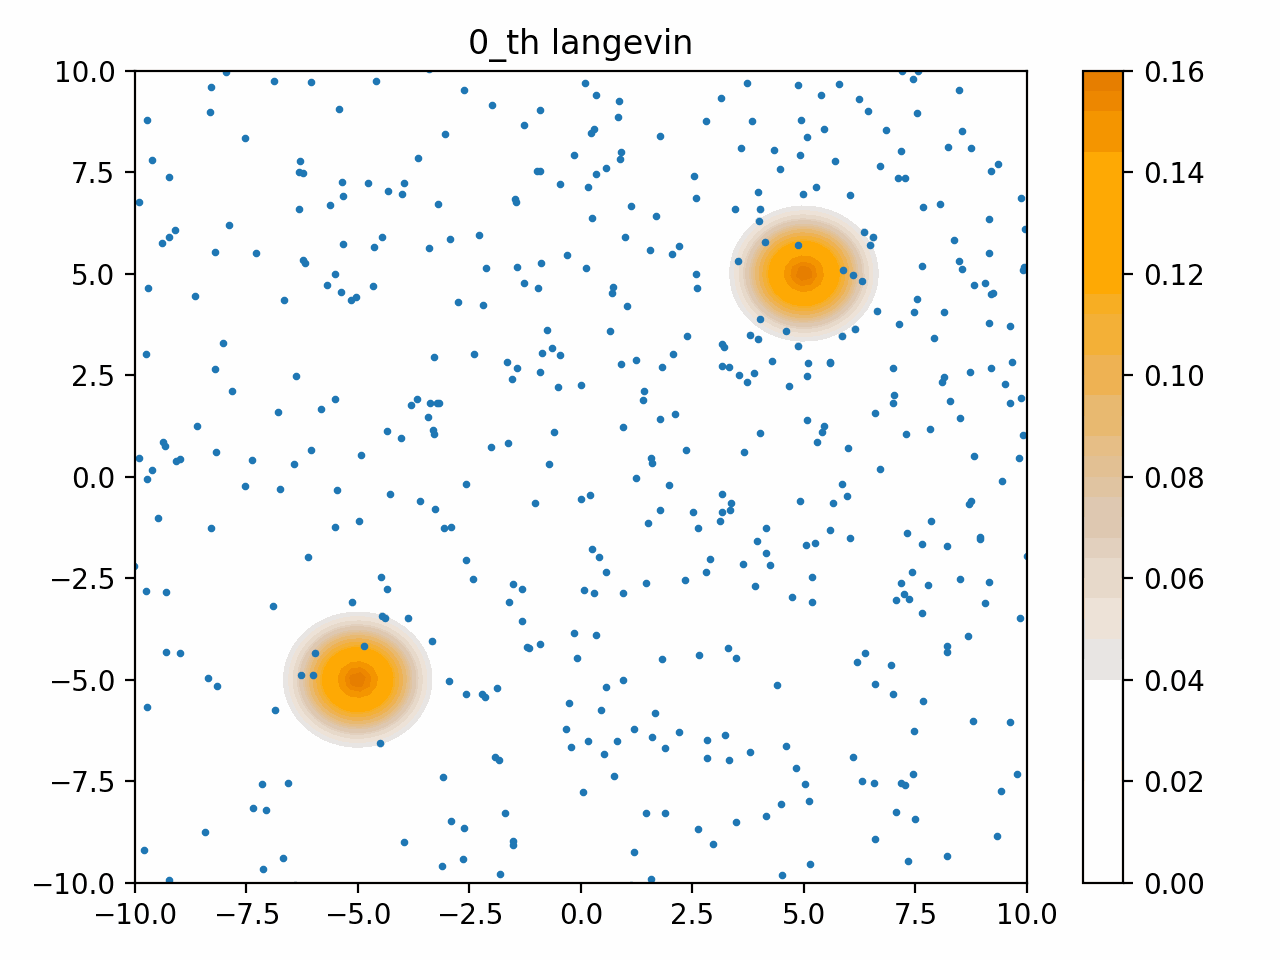

In [ ]:
gif_config = {
    'loop':0, ## 0으로 세팅하면 무한 반복, 3으로 설정하면 3번 반복
    'duration': 100 ## 다음 화면으로 넘어가는 시간
}
gif_name = './gif/wrong_reverse.gif'
generate_gif(filenames,gif_name,removing=True,gif_config=gif_config)
Image(open(f'{gif_name}','rb').read(),width=500, height=500)

# Score function Training
기존의 방식으로는 wrong score function을 구할 수 없음.   
score network를 생성하여 실험을 해보자

In [21]:
p1 = pdf(mean[0],cov[0],data_num)
p2 = pdf(mean[1],cov[0],data_num)
pi = 1/5
print("p1:shape {}// p2:shape {}".format(p1.shape, p2.shape))
print(int(data_num*pi),int(data_num*(1-pi)))
p1 = p1[:,:int(data_num*pi)]
p2 = p2[:,:int(data_num*(1-pi))]
print(p1.shape, p2.shape)
###########
# cov =
data = np.hstack((p1,p2))

tensor = torch.tensor(data).float().T
# 분포의 평균이 이미 0이라 normalize를 따로 진행하지 않음
dataset = torch.utils.data.TensorDataset(tensor)
print(dataset.__getitem__(0))

p1:shape (2, 1280)// p2:shape (2, 1280)
256 1024
(2, 256) (2, 1024)
(tensor([ -9.1664, -11.8953]),)


In [30]:
# Generate Score Network
score_network = torch.nn.Sequential(
    torch.nn.Linear(2, 64),  # input is 2d array
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2), # output also means coordinate
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

score_network.to(device) # model to device , using GPU
dloader = torch.utils.data.DataLoader(dataset, batch_size =512, shuffle=True)
optimizer = torch.optim.Adam(score_network.parameters(),lr =1e-04)

# Set Loss function (Object Function)
$\frac{1}{2}E[||s_{\theta}(x)-\nabla_x\;log\;p_{data}(x)||_2^2]$
where we don't know $\nabla_x\;log\;p_{data}(x)$  
So, We use
![image.png](attachment:d7dc9f70-9743-46e7-b9a7-58637404ca65.png)

Jacovian과 vmap의 역활
```python
import torch
from functorch import jacrev, vmap

# Define a simple function
def f(x):
    return x ** 3

# Compute the jacobian of f at x=2
x = torch.tensor(2.)
jacobian = torch.func.jacrev(f)(x)
print(jacobian)  # Output: tensor(12.) because derivative of x^3 at x=2 is 3*2^2 = 12

# Compute f(x) for a batch of x values
x_batch = torch.tensor([1., 2., 3.])
f_batch = torch.vmap(f)(x_batch)
print(f_batch)  # Output: tensor([1., 8., 27.]) because 1^3 = 1, 2^3 = 8, 3^3 = 27
```

In [31]:
# from functorch import jacrev, vmap
# n개의 분포가 있으면 n개의 score를 각각 구해야한다.
# 이는 각 분포에 대해서 추정이 어렵기에 NN으로 구현을 해볼 생각
def calc_loss(score_net: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    score = score_net(x)  # score: (batch_size, 2)
    jacobian = torch.vmap(torch.func.jacrev(score_net))(x) # calculate trace
    # jacrev: using backpropagation jacov 행렬을 계산함
    # ()안에 함수에 대해서 미분을 계산하여 jarcov로 만들고, x를 넣는 방식
    # vmap: 주어진 함수를 배치 차원을 따라 벡터화하는 함수, x 각각에 대해서 함수를 적용하도록 작동
    score_loss_1 = 0.5 * (torch.norm(score, dim=1) ** 2)
    score_loss_2 = jacobian.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
    # score_loss_2 = torch.trace(jacobian)과 같음
    # offset: 주 대각 성분을 의미함, -1일 경우 대각 성분의 아래, 1일 경우 대각 성분의 위
    return torch.mean(score_loss_1 + score_loss_2)
def make_vector_field(score_network, plot_lim = 10,device='cpu'):
    x = np.linspace(-plot_lim, plot_lim, plot_lim*2)
    y = np.linspace(-plot_lim, plot_lim, plot_lim*2)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape + (2,))
    #각 x,y의 mesh grid에 대해서 계산을 해야함. point wise로 score를 구한다고 생각하면 될 듯
    # score_network.to(device)
    with torch.no_grad():
        for i in range(Z.shape[0]):
            for j in range(Z.shape[1]):
                Z[i, j] = score_network(torch.tensor((X[i][j], Y[i][j])).float().reshape(-1,2).to(device)).detach().cpu()
    return X,Y,Z
    # plt.quiver(X, Y, Z[...,0],Z[...,1], color='black')
    # plt.show()

def plot_result(xt,iteration,score_network,plot_lim=20,show=False,device='cpu' ):
    filenames = []
    plt.title(f"{iteration}_th reverse show")
    plt.xlim([-plot_lim,plot_lim])
    plt.ylim([-plot_lim,plot_lim])

    X,Y,Z = contourf(mean[0],cov[0],plot_lim,100)
    A,B,C = contourf(mean[1],cov[1],plot_lim,100)
    plt.contourf(np.hstack((X,A)),np.hstack((Y,B)),np.hstack((Z,C)),levels=50,cmap=cmap) #levels means # of circle
    plt.colorbar()


    Q,W,E  = make_vector_field(score_network,plot_lim,device)

    plt.quiver(Q, W,E[...,0],E[...,1], color='black')

    plot = xt.clone().detach().cpu().T
    plt.scatter(plot[0],plot[1],s=1)
    plt.tight_layout()
    filename = f"./HW2_reverse/score_{iteration}_reverse.png"
    plt.savefig(filename,dpi=200)
    if show:
        plt.show()
        # time.sleep(0.01)
        clear_output(wait=True)
    plt.close()
    return filename

# Model Training

In [32]:
# start the training loop
import time
t0 = time.time()
train_loss = []
score_network.train()
for i_epoch in tqdm(range(1000)):
    total_loss = 0
    for data, in dloader:
        # print(data)
        data = data.to(device)
        optimizer.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        optimizer.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 250 == 0:
        print(f"{i_epoch} ({np.round(time.time() - t0,3)}s): {total_loss / len(dataset)}")
    train_loss = np.append(train_loss ,loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

0 (3.504s): 0.5664316415786743
250 (16.795s): -0.8238924503326416
500 (35.644s): -0.937125813961029
750 (41.162s): -0.9672911047935486


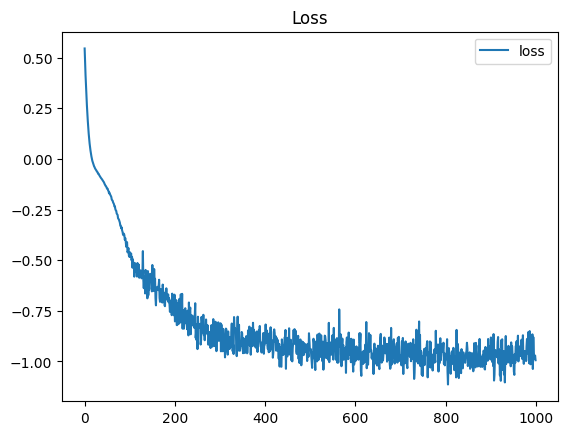

In [34]:
plt.plot(train_loss,label='loss')
plt.legend()
plt.title('Loss')
plt.show()

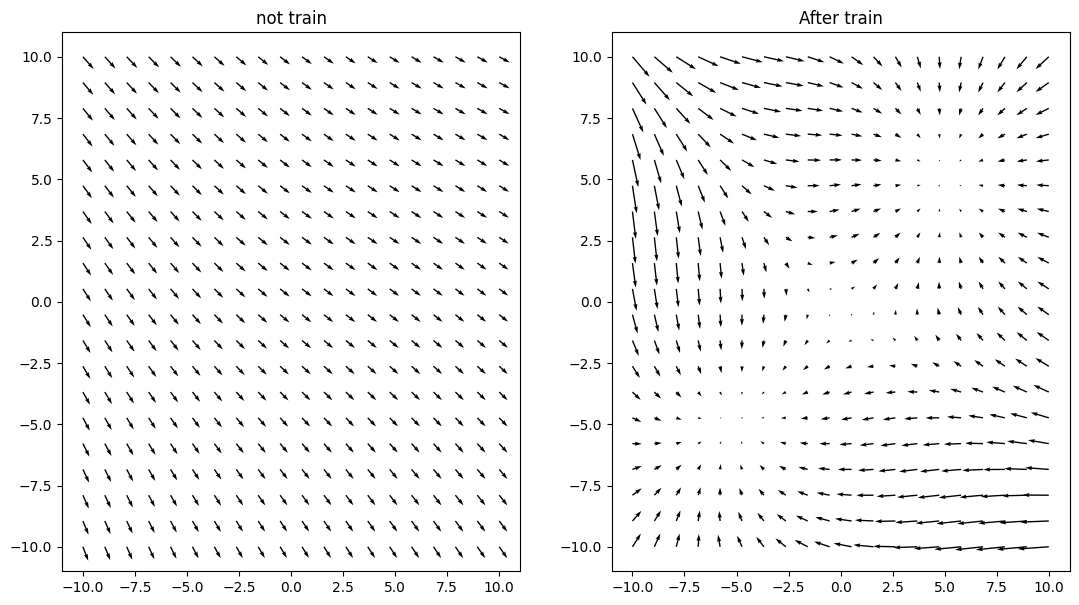

In [101]:
test = torch.nn.Sequential(
    torch.nn.Linear(2, 64),  # input is 2d array
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2), # output also means coordinate
)
Q,W,E = make_vector_field(test.to(device), 10,device)
X,Y,Z = make_vector_field(score_network, 10,device)
plt.figure(figsize=(13,7))
plt.subplot(121)
plt.title("not train")
plt.quiver(Q,W,E[...,0],E[...,1], color='black')
plt.subplot(122)
plt.title("After train")
plt.quiver(X, Y,Z[...,0],Z[...,1], color='black')
plt.savefig("./Langevin Dynamics_Vector_field.png")
plt.show()

# Score Generation with Langevin Dynamics


In [36]:
noise_data = torch.tensor(forward_list[-1])

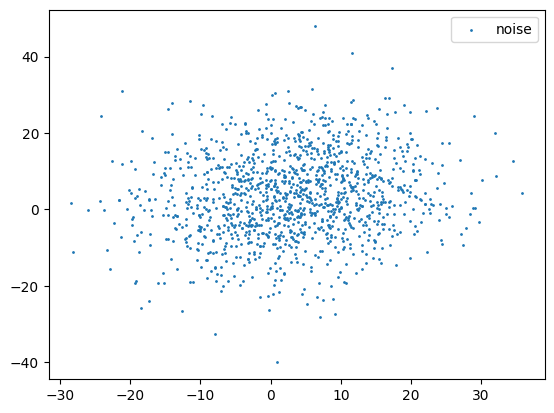

In [37]:
plt.scatter(noise_data[0],noise_data[1],s=1,label='noise')
plt.legend()
plt.show()


<!-- $\sigma_1= 10$   -->
<!-- $\sigma_{10}= 0.1$   -->
$T=1000$  
$\epsilon = 0.1$

In [39]:
gif_path = "./HW2_reverse"
if not os.path.isdir(gif_path):  #path가 존재하지 않는다면 path를 생성합니다.
    os.mkdir(gif_path)


In [104]:
def generate_samples(score_network: torch.nn.Module,data: torch.Tensor, eps: float = 0.1, T: int = 1000) -> torch.Tensor:
    # new_x = torch.rand(nsamples, 2)
    xt = data.float().to(device).T
    filenames = []
    # score_network.to(device)
    for i in tqdm(range(T)):
        brownian = torch.randn_like(xt)
        with torch.no_grad():
            xt = xt + (0.5*eps * score_network(xt)) +  (np.sqrt(2 * eps)) * brownian
        #### plot 하기 위한 함수들
        filenames.append(plot_result(xt,i,score_network,plot_lim=10,show=False,device=device ))


    return xt , filenames

with torch.no_grad():
    score_network.eval()
    samples,filenames = generate_samples(score_network, noise_data,T = 100)


  0%|          | 0/100 [00:00<?, ?it/s]

In [105]:
gif_config = {
    'loop':0, ## 0으로 세팅하면 무한 반복, 3으로 설정하면 3번 반복
    'duration': 0.01 ## 다음 화면으로 넘어가는 시간
}
gif_name = './gif/Score_network_Langevin.gif'
generate_gif(filenames,gif_name,removing=False,gif_config=gif_config)
Image(open(f'{gif_name}','rb').read(),width=500, height=500)

Output hidden; open in https://colab.research.google.com to view.

# Annealed Langevin Dynamics
$\alpha_i = \epsilon \cdot \frac{\sigma^2_i}{\sigma^2_L}$

$\{\sigma_i\}^L_{i=1}$: Positive geometric sequence  
$\frac{\sigma_1}{\sigma_2}=\frac{\sigma_2}{\sigma_3}=\cdots=\frac{\sigma_{L-1}}{\sigma_L}>1$

Paper 7 page  and appendix b.1

for annealed
$T = 100$
$L=10$  
$\sigma_1=20$  
$\sigma_{10}=1$  

----
for image generation,   
$L=10$  
$\sigma_1= 10$  
$\sigma_{10}= 0.01$  
$T = 100$  
$\epsilon = 2 \times 1e-5$

직접 계산할 때
```python
L = 10
sigma_1 = 10
sigma_10 = 0.1

sigma = []
print("ratio", sigma_10**(1.0/(L-1)))
for i in range(L):
    if i==0:
        sigma.append(sigma_1)
    else:
        sigma.append(np.round(sigma[-1]*(sigma_10**(1.0/(L-1))),6))
print(sigma[0]/sigma[1], sigma[1]/sigma[2], sigma[-2]/sigma[-1])        
```

In [42]:
# 내장함수로 등비 급수를 쉽게 계산할 수 있음
sigma = np.geomspace(20,1,10)
sigma = torch.tensor(sigma).float()
sigma[0]/sigma[1], sigma[1]/sigma[2],sigma[-2]/sigma[-1]

(tensor(1.3950), tensor(1.3950), tensor(1.3950))

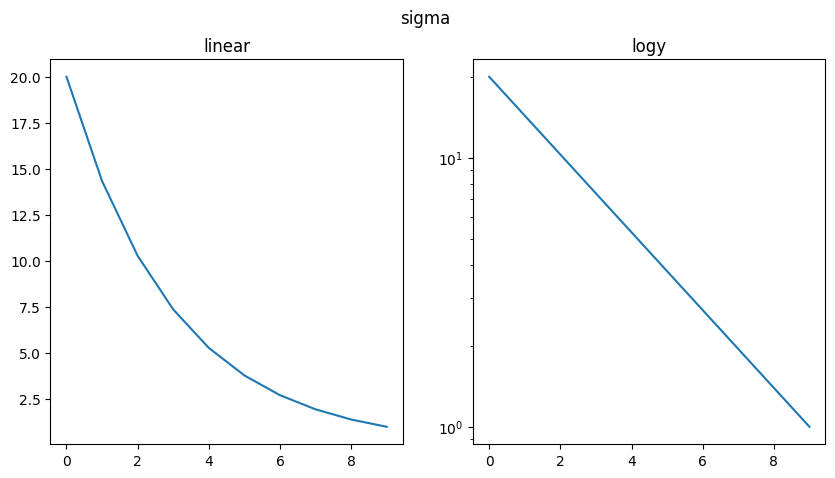

In [44]:
plt.figure(figsize=(10,5))
plt.suptitle('sigma')
plt.subplot(121)
plt.plot(sigma)
plt.title('linear')
plt.subplot(122)
plt.semilogy(sigma)
plt.title('logy')
plt.show()



In [22]:
def make_vector_field2(score_network,sigma, plot_lim = 10,device='cpu'):
    x = np.linspace(-plot_lim, plot_lim, plot_lim*2)
    y = np.linspace(-plot_lim, plot_lim, plot_lim*2)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape + (2,))
    #각 x,y의 mesh grid에 대해서 계산을 해야함. point wise로 score를 구한다고 생각하면 될 듯
    # score_network.to(device)
    with torch.no_grad():
        for i in range(Z.shape[0]):
            for j in range(Z.shape[1]):
                Z[i, j] = score_network(torch.tensor((X[i][j], Y[i][j],sigma)).float().reshape(-1,3).cuda()).detach().cpu()
    return X,Y,Z
    # plt.quiver(X, Y, Z[...,0],Z[...,1], color='black')
    # plt.show()

def plot_result2(xt,sigma,L,iteration,score_network,plot_lim=20,show=False,device='cpu' ):
    filenames = []
    plt.title(f"sigma{L}th_{iteration}_th reverse show")
    plt.xlim([-plot_lim,plot_lim])
    plt.ylim([-plot_lim,plot_lim])

    X,Y,Z = contourf(mean[0],cov[0],plot_lim,100)
    A,B,C = contourf(mean[1],cov[1],plot_lim,100)
    plt.contourf(np.hstack((X,A)),np.hstack((Y,B)),np.hstack((Z,C)),levels=50,cmap=cmap) #levels means # of circle
    plt.colorbar()


    Q,W,E  = make_vector_field2(score_network,sigma,plot_lim,device)

    plt.quiver(Q, W,E[...,0],E[...,1], color='black')

    plot = xt.clone().detach().cpu().T
    plt.scatter(plot[0],plot[1],s=1)
    plt.tight_layout()
    filename = f"./HW2_reverse/sigma{L}_{iteration}_Annealed_reverse.png"
    plt.savefig(filename,dpi=200)
    if show:
        plt.show()
        # time.sleep(0.01)
        clear_output(wait=True)
    plt.close()
    return filename

In [82]:
# score_network takes input of 2 + 1 (noise) and returns the output of the same size (2)
score_network2 = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)
score_network2.to(device)
optimizer = torch.optim.Adam(score_network2.parameters(), lr = 1e-4)
dloader = torch.utils.data.DataLoader(dataset, batch_size = 1280, shuffle=True)


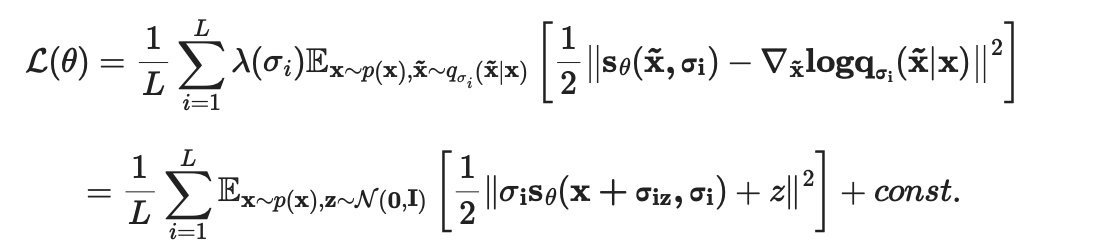

In [56]:
sigmas = torch.tensor(np.geo)

tensor([20.0000, 14.3374, 10.2781,  7.3681,  5.2820,  3.7865,  2.7144,  1.9459,
         1.3950,  1.0000])

In [28]:
# L = 10
# T = 100
#### 논문대로 했을 때 결과가 잘나오지 않음.
# def calc_loss(score_network,x,sigma)-> torch.Tensor:
#     # x: (batch_size, 2) is the training data
#     # Sampling a mini-batch from noise scale indices
#     Sigma = (torch.ones(data.shape[0])*sigma).reshape(-1,1).to(device)
#     new_input = torch.cat((x,Sigma),1) #sigma
#     output = score_network2(new_input)
#     # output*sigma[0]+(output-data)/sigma[0]
#     loss = torch.mean(0.5 * (torch.norm(output*sigma+(output-x)/sigma, dim=1) ** 2))
#     return loss
# sigmas = torch.linspace(0.001, 0.04, steps=1000)
sigmas = np.geomspace(20,0.1,1000)
sigmas = torch.tensor(sigmas).float()
def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    # Sampling a mini-batch from noise scale indices
    sig_idx = torch.randperm(len(sigmas))[:len(x)]
    sig_samples = sigmas[sig_idx].view(-1,1).to(device)
    # Sampling a mini-batch from Gaussian noise
    z = torch.randn_like(x)
    perturbed_inputs = x + sig_samples * z
    net_input = torch.cat([perturbed_inputs, sig_samples],dim = 1)
    term_one = score_network2(net_input) * sig_samples
    loss = torch.mean(0.5 * (torch.norm(term_one + z, dim=1) ** 2))

    return loss

In [66]:
# # start the training loop
# import time

# t0 = time.time()
# train_loss2 = []
# for i in tqdm(range(L)): #sigma

#     for i_epoch in tqdm(range(2000),leave=False):
#         total_loss = 0
#         for data, in dloader:
#             data = data.to(device)
#             optimizer.zero_grad()

#             # training step
#             loss = calc_loss(score_network2, data,sigma[i])
#             loss.backward()
#             optimizer.step()

#             # running stats
#             total_loss = total_loss + loss.detach().item() * data.shape[0]

#         # print the training stats
#         if i_epoch % 1000 == 0:
#             print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dataset)}")
#         train_loss2 = np.append(train_loss2 ,loss.item())

In [83]:
# start the training loop
import time
optim = torch.optim.Adam(score_network2.parameters(), lr = 3e-4)
dloader = torch.utils.data.DataLoader(dataset, batch_size = 256, shuffle=True)
t0 = time.time()
train_loss2 = []
for i_epoch in tqdm(range(20000)):
    total_loss = 0
    for data, in dloader:
        optim.zero_grad()
        data = data.to(device)
        # training step
        loss = calc_loss(score_network2, data)
        loss.backward()
        optim.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 1000 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dataset)}")
    train_loss2 = np.append(train_loss2 ,loss.item())

  0%|          | 0/20000 [00:00<?, ?it/s]

0 (0.050461530685424805s): 36.38197021484375
1000 (16.71189546585083s): 0.48833211064338683
2000 (32.59892416000366s): 0.5056686937808991
3000 (48.83600401878357s): 0.4610833883285522
4000 (65.44113445281982s): 0.4919750154018402
5000 (81.53675746917725s): 0.4857824444770813
6000 (97.51332235336304s): 0.47441956400871277
7000 (114.11864137649536s): 0.5247622609138489
8000 (130.27967476844788s): 0.5014736890792847
9000 (147.38064575195312s): 0.4865044355392456
10000 (164.06982374191284s): 0.48495818972587584
11000 (180.11417317390442s): 0.48571916818618777
12000 (196.21431040763855s): 0.4764745533466339
13000 (212.73990774154663s): 0.510846209526062
14000 (228.8666684627533s): 0.46304923892021177
15000 (245.1741282939911s): 0.4818708419799805
16000 (261.85329270362854s): 0.47925129532814026
17000 (277.8995740413666s): 0.4848993122577667
18000 (293.86172747612s): 0.4846063733100891
19000 (311.3336193561554s): 0.4543318450450897


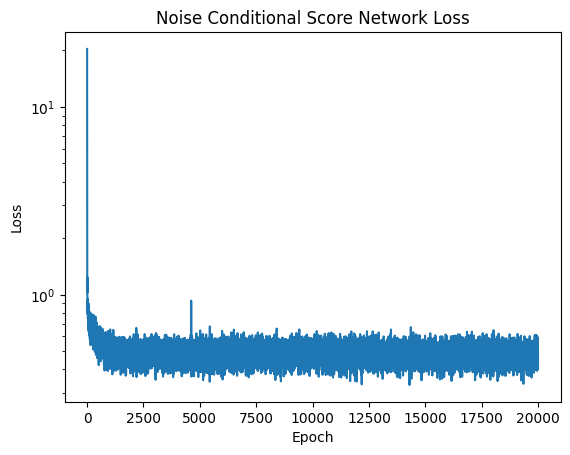

In [85]:
plt.semilogy(train_loss2)
plt.title('Noise Conditional Score Network Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [29]:
# # 내장함수로 등비 급수를 쉽게 계산할 수 있음
sigma2 = np.geomspace(20,0.0001,10)
sigma2 = torch.tensor(sigma2).float()
sigma2
# # sigma[0]/sigma[1], sigma[1]/sigma[2],sigma[-2]/sigma[-1]

tensor([2.0000e+01, 5.1526e+00, 1.3275e+00, 3.4200e-01, 8.8108e-02, 2.2699e-02,
        5.8480e-03, 1.5066e-03, 3.8815e-04, 1.0000e-04])

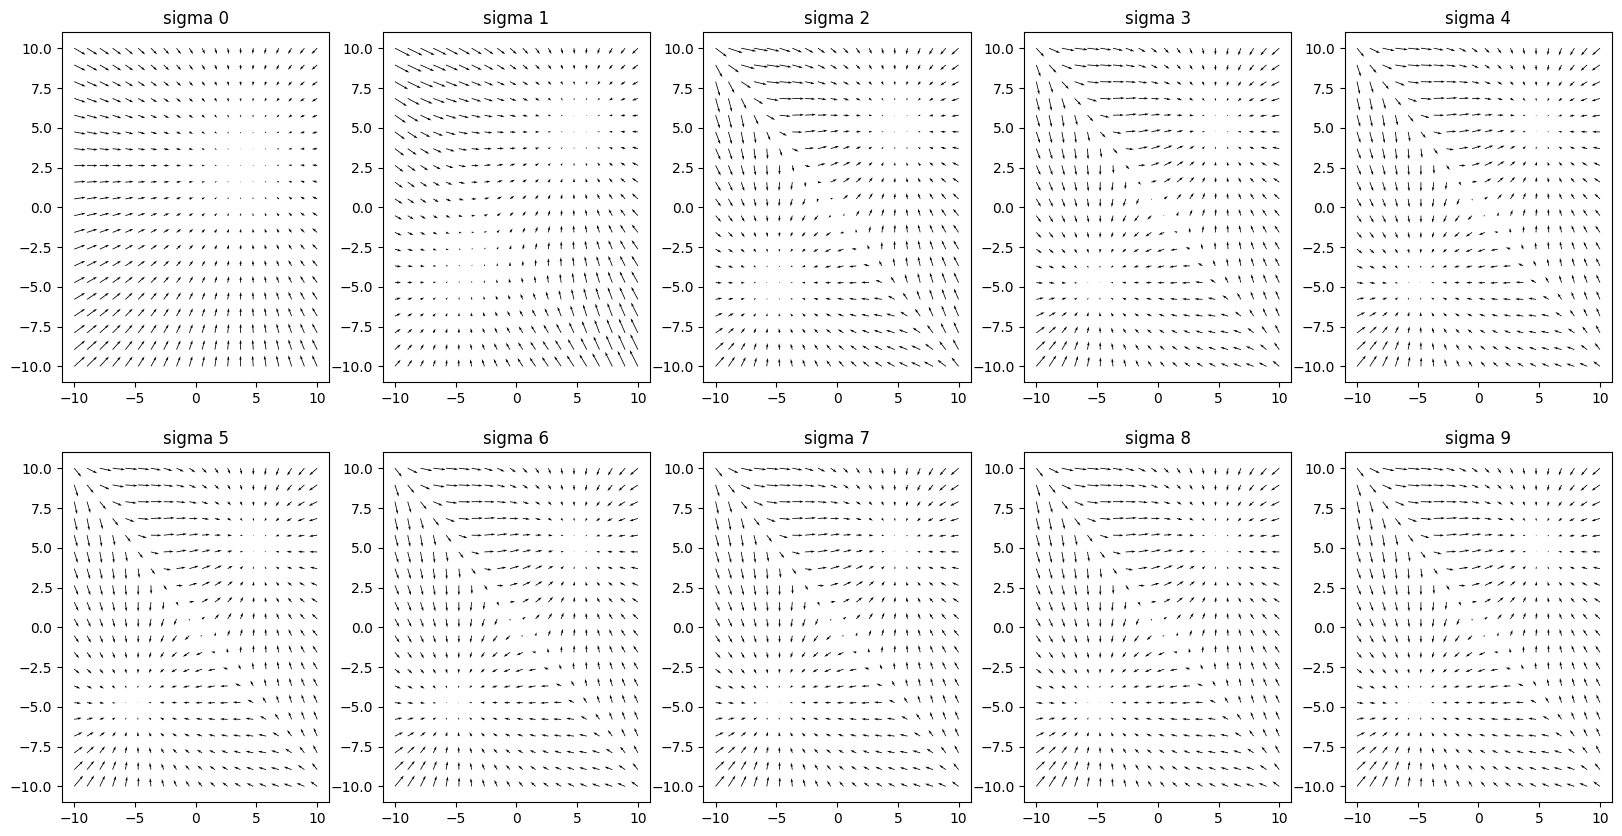

In [102]:
f,ax = plt.subplots(2,5,figsize = (20,10))
for i in range(2):
    for j in range(5):
        X,Y,Z = make_vector_field2(score_network2,sigma2[i*5+j], plot_lim = 10,device='cpu')
        ax[i,j].set_title(f"sigma {i*5+j}")
        ax[i,j].quiver(X, Y,Z[...,0],Z[...,1], color='black')
plt.savefig("./Annealed_Langevin_Dynamics_SigmaTest.png")

plt.show()

# sigma1 > L까지 가는 동안 분리가 되는 것을 확인할 수 있다.

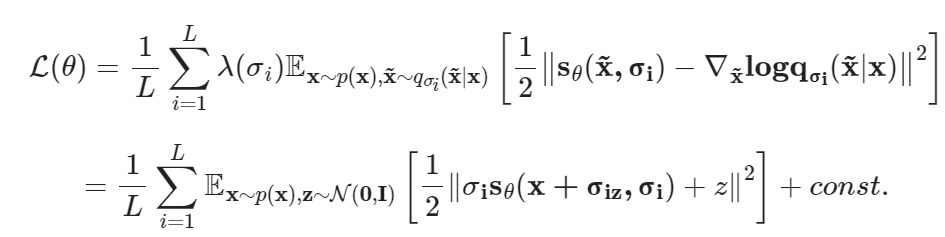

In [96]:


def generate_samples_2(score_net,data,sigma,L=10,T=100, eps: float = 0.1) -> torch.Tensor:

    xt = data.float().to(device).T
    filenames = []
    t0 = time.time()

    with torch.no_grad():
        for i in tqdm(range(L)): # sigma
            alpha = (eps * (sigma[i] / sigma[-1]))
            files = []
            for t in tqdm(range(T),leave=False):
                brownian = torch.randn_like(xt)
                # print(sigma[i].shape, sigma[i], torch.ones(xt.shape[0]).shape)
                Sigma = (torch.ones(xt.shape[0])*sigma[i]).reshape(-1,1).to(device)
                new_input = torch.cat((xt,Sigma),1) #sigma
                output = score_net(new_input)
                xt = xt + ((alpha/2) *output) +  (alpha ** 0.5) * brownian

                #### plot 하기 위한 함수들
                files.append(plot_result2(xt,sigma[i],i,t,score_net,plot_lim=10,show=False,device=device ))

            if t % 50 == 0:
                print(f"{t}, {time.time() - t0}s")
            filenames.append(files)
    return  xt, filenames



with torch.no_grad():
    score_network.eval()
    samples,filenames = generate_samples_2(score_network2,noise_data,sigma ,T = 100)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [99]:
 gif_config = {
    'loop':0, ## 0으로 세팅하면 무한 반복, 3으로 설정하면 3번 반복
    'duration': 0.001 ## 다음 화면으로 넘어가는 시간
}
gif_name = './gif/Score_network_annealed_Langevin.gif'
generate_gif(filenames[0],gif_name,removing=False,gif_config=gif_config)
Image(open(f'{gif_name}','rb').read(),width=500, height=500)

Output hidden; open in https://colab.research.google.com to view.

In [100]:
 gif_config = {
    'loop':0, ## 0으로 세팅하면 무한 반복, 3으로 설정하면 3번 반복
    'duration': 0.01 ## 다음 화면으로 넘어가는 시간
}
gif_name = './gif/Score_network_annealed_Langevin_sigma_max.gif'
generate_gif(filenames[-1],gif_name,removing=False,gif_config=gif_config)
Image(open(f'{gif_name}','rb').read(),width=500, height=500)

Output hidden; open in https://colab.research.google.com to view.

In [3]:
# score_network takes input of 2 + 1 (noise) and returns the output of the same size (2)
score_network2 = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)

p1:shape (2, 1280)// p2:shape (2, 1280)
(tensor([-10.8611, -10.0775]),)


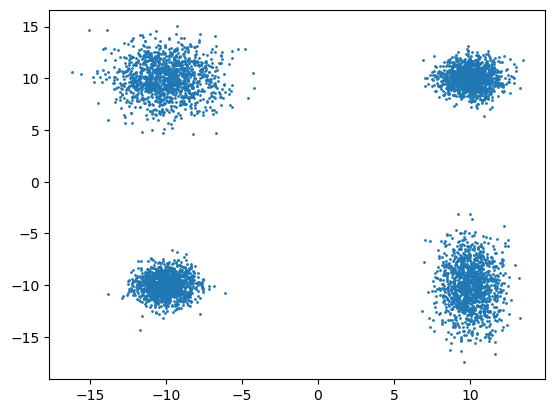

In [23]:
mean = np.array([[-10,-10],[10,10],[-10,10],[10,-10]])

plot_lim = 20
cov = [[[1,0],[0,1]],[[1,0],[0,1]],[[3,0],[0,3]],[[1,0],[0,5]]]

p1 = pdf(mean[0],cov[0],data_num)
p2 = pdf(mean[1],cov[1],data_num)
p3 = pdf(mean[2],cov[2],data_num)
p4 = pdf(mean[3],cov[3],data_num)


# pi = 1/5
print("p1:shape {}// p2:shape {}".format(p1.shape, p2.shape))
# print(int(data_num*pi),int(data_num*(1-pi)))
# p1 = p1[:,:int(data_num*pi)]
# p2 = p2[:,:int(data_num*(1-pi))]
# print(p1.shape, p2.shape)
##########
# cov =
data = np.hstack((p1,p2,p3,p4))

tensor = torch.tensor(data).float().T
# 분포의 평균이 이미 0이라 normalize를 따로 진행하지 않음
dataset = torch.utils.data.TensorDataset(tensor)
print(dataset.__getitem__(0))
plt.scatter(data[0],data[1],s=1)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

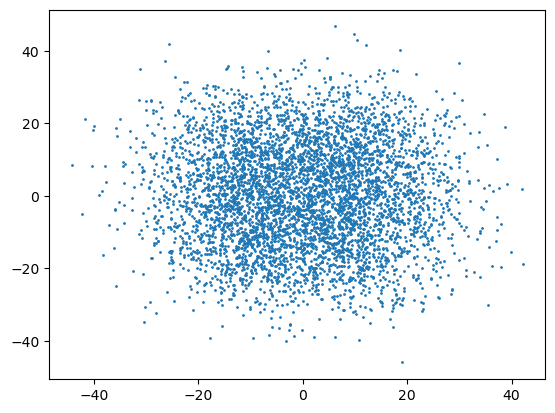

In [24]:
show = False
# filenames = []
forward_list =[]
for i in tqdm(range(100)):
    if i==0:
        forward_list.append(data)

    else:
        sample = forward_list[-1]
        N = noise2d(len(sample[0]))
        forward_list.append(sample+N)
real_data = forward_list[-1]
plt.scatter(real_data[0],real_data[1],s=1)
plt.show()

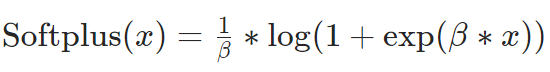

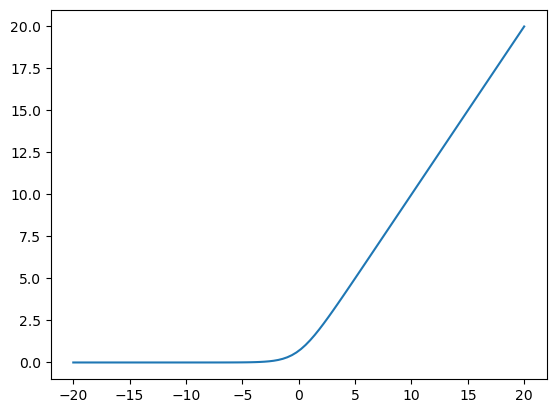

In [19]:
x = np.linspace(-20,20,100)
x.shape
plt.plot(x,nn.Softplus()(torch.tensor(x)))
plt.show()

In [26]:
# score_network takes input of 2 + 1 (noise) and returns the output of the same size (2)
score_network2 = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.Softplus(),
    torch.nn.Linear(128, 128),
    torch.nn.Softplus(),
    torch.nn.Linear(128, 128),
    torch.nn.Softplus(),
    torch.nn.Linear(128, 2),
)
device = 'cuda'
score_network2.to(device)
optimizer = torch.optim.Adam(score_network2.parameters(), lr = 1e-4)
dloader = torch.utils.data.DataLoader(dataset, batch_size = 1280, shuffle=True)


In [ ]:
# start the training loop
import time
optim = torch.optim.Adam(score_network2.parameters(), lr = 3e-4)
dloader = torch.utils.data.DataLoader(dataset, batch_size = 256, shuffle=True)
t0 = time.time()
train_loss2 = []
for i_epoch in tqdm(range(5000)):
    total_loss = 0
    for data, in dloader:
        optim.zero_grad()
        data = data.to(device)
        # training step
        loss = calc_loss(score_network2, data)
        loss.backward()
        optim.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 1000 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dataset)}")
    train_loss2 = np.append(train_loss2 ,loss.item())

  0%|          | 0/5000 [00:00<?, ?it/s]

0 (0.9803769588470459s): 4.422228324413299
1000 (64.66676664352417s): 0.5898760467767715
2000 (130.44288063049316s): 0.5893754869699478
3000 (196.65020036697388s): 0.5986776947975159


In [ ]:
f,ax = plt.subplots(2,5,figsize = (20,10))
for i in range(2):
    for j in range(5):
        X,Y,Z = make_vector_field2(score_network2,sigma2[i*5+j], plot_lim = 10,device='cpu')
        ax[i,j].set_title(f"sigma {i*5+j}")
        ax[i,j].quiver(X, Y,Z[...,0],Z[...,1], color='black')
plt.savefig("./Annealed_Langevin_Dynamics_SigmaTest3.png")

plt.show()

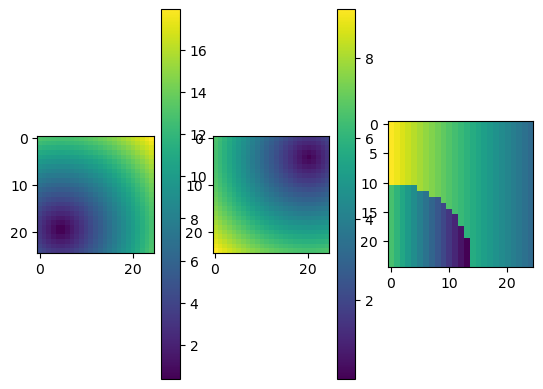

In [ ]:

plt.subplot(141)
plt.imshow(norms1)
plt.colorbar()
plt.subplot(142)
plt.imshow(norms2)
plt.colorbar()
plt.subplot(143)
plt.subplot(144)

plt.imshow(Z_quiver_max[::-1,:,0])
plt.show()